#**Transfer Learning with MobileNet for CIFAR-10 Classification**

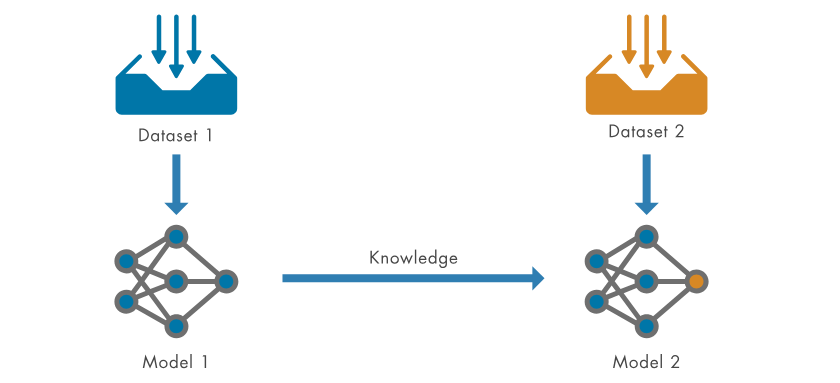


**Transfer learning** is a technique where a pre-trained model, developed on a large dataset, is adapted to a new, related task. Instead of training a model from scratch, the model leverages learned features from the original task and is fine-tuned for the new task, making it especially useful when limited data is available. This approach speeds up training and improves performance, particularly in fields like **image classification** and **natural language processing**.


##**About Notebook**
A deep learning model using the **MobileNet architecture** with transfer learning to classify images from the CIFAR-10 dataset.
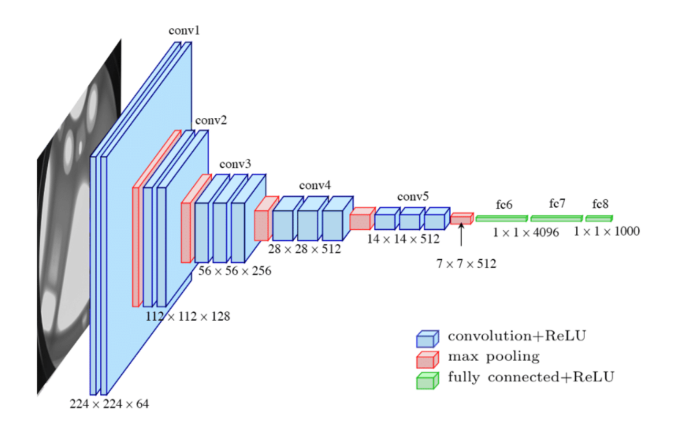
#### **Key Steps for fine-tuning the model with custom layers and preprocessing:**
1. **Data Loading and Preprocessing:**
   - The CIFAR-10 dataset is loaded with `train` and `validation` splits.
   - Images are preprocessed using MobileNet's built-in `preprocess_input` function, which prepares them for transfer learning with the MobileNet model.
   - The class labels (`y_train` and `y_validation`) are converted into one-hot encoded vectors using `tf.keras.utils.to_categorical`.

2. **Model Architecture:**
   - A pre-trained MobileNet model is loaded with the top classification layer removed (`include_top=False`), making it suitable for feature extraction.
   - The model is modified by adding a `Flatten` layer followed by two fully connected (`Dense`) layers with 512 neurons each, and `Dropout` layers to reduce overfitting.
   - The final output layer consists of 10 neurons, corresponding to the 10 CIFAR-10 classes, with a `softmax` activation function.

3. **Training Setup:**
   - The model is compiled using the AdamW optimizer with a small learning rate and weight decay for regularization.
   - The loss function is categorical crossentropy, appropriate for multi-class classification tasks.
   - The model is trained for 20 epochs with a batch size of 256, using the CIFAR-10 training and validation sets.

### Possible Improvements and Considerations (Future):
- **Layer Freezing:**  
  Option to freeze the first 20 layers of the MobileNet model, which would prevent them from being updated during training, thus employing the pre-trained weights for feature extraction while training the newly added layers.
  


###**Library Imports**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
#The CIFAR-10 dataset -- Testing data is used as validation data in this context
(x_train, y_train),(x_validation, y_validation) = tf.keras.datasets.cifar10.load_data()
print(f"Number of training images: {len(x_train)}, Number of validation images: {len(x_validation)}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Number of training images: 50000, Number of validation images: 10000


##**Preprocessing Data using MobileNet Architecture**

In [3]:
x_train = tf.keras.applications.mobilenet.preprocess_input(x_train)
x_validation = tf.keras.applications.mobilenet.preprocess_input(x_validation)

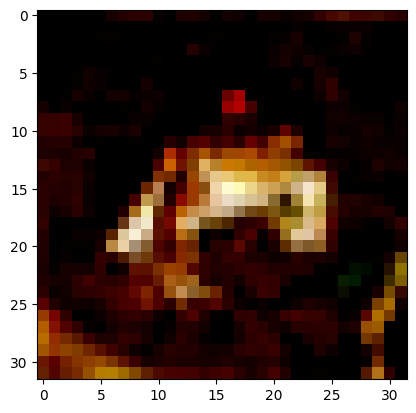

In [4]:
plt.imshow(x_train[0])

In [5]:
y_train[0] # Before encoding: y_train[0] contains the class label as an integer (0 to 9)

array([6], dtype=uint8)

In [6]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_validation = tf.keras.utils.to_categorical(y_validation, num_classes=10)

In [7]:
y_train[0] # After one-hot encoding: y_train[0] now contains the label as a one-hot vector

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

##**Pretrained MobileNet Model Setup**

In [8]:
#pretrained model
base_model = tf.keras.applications.MobileNet()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
base_model.summary() #Displays MobileNet Architecture

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

The final fully connected dense layer, following GlobalAveragePooling, will be modified to output 10 neurons, corresponding to the 10 CIFAR-10 categories.

##**Modify MobileNet for CIFAR-10 Classification**

In [10]:
base_model = tf.keras.applications.MobileNet(include_top=False, input_shape=(32,32,3))
base_model.summary()
# Model is ready for feature extraction
# Only update the parameters of the layers that were added by us during forward and backward propagation in the training process.

<ipython-input-10-957f2643b845>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNet(include_top=False, input_shape=(32,32,3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 16, 16, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 16, 16, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 16, 16, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 16, 16, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 16, 16, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 16, 16, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 8, 8, 64)            │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 8, 8, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 8, 8, 128)           │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 8, 8, 128)           │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 8, 8, 128)           │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 8, 8, 128)           │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 8, 8, 128)           │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [11]:
base_model.trainable = True
'''
Further Work to visualize the effect of freezing certain layers on the model.
# Freeze the first 20 layers
for layer in base_model.layers[:20]:
    layer.trainable = False
'''

'\nFurther Work to visualize the effect of freezing certain layers on the model.\n# Freeze the first 20 layers\nfor layer in base_model.layers[:20]:\n    layer.trainable = False\n'

In [12]:
#The Sequential API can be utilized for the time being.
model = tf.keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'), #512 Neurons
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax') #10 Neurons for the 10 classes
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 1, 1, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,021,450 (15.34 MB)

 Trainable params: 3,999,562 (15.26 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [13]:
model.compile(
    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.0004),
    loss = tf.keras.losses.categorical_crossentropy,
    metrics = ['accuracy']
)
model.fit(x_train, y_train, validation_data = (x_validation, y_validation), epochs = 20, batch_size = 256)

Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 100ms/step - accuracy: 0.2635 - loss: 2.2017 - val_accuracy: 0.4988 - val_loss: 1.5628
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5867 - loss: 1.1719 - val_accuracy: 0.6397 - val_loss: 1.0494
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6783 - loss: 0.9163 - val_accuracy: 0.6757 - val_loss: 0.9253
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7328 - loss: 0.7614 - val_accuracy: 0.7024 - val_loss: 0.8637
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7803 - loss: 0.6252 - val_accuracy: 0.7138 - val_loss: 0.8451
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8140 - loss: 0.5302 - val_accuracy: 0.7283 - val_loss: 0.8257
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8453 - loss: 0.4435 - val_accuracy: 0.7269 - val_loss: 0.8568
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8729 - loss: 0.3661 - val_a